<a href="https://colab.research.google.com/github/RiccardoRobb/BigData_project/blob/main/BigData_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter sentiment analysis**
### BigData 2023 project

[@Author](https://github.com/RiccardoRobb): Riccardo Ruberto 1860609

---
## **Inital configuration**
### PySpark installation

In [3]:
! pip install pyspark

### Useful imports

In [4]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Spark configuration

In [5]:
# create the session
conf = SparkConf().\
                set('spark.ui.port', "8000").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("Twitter sentiment analysis").\
                setMaster("local[*]")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Check spark configurations

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.app.submitTime', '1693479531512'),
 ('spark.driver.host', '87a0b48fa318'),
 ('spark.driver.memory', '45G'),
 ('spark.app.id', 'local-1693479536792'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.ui.port', '8000'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.startTime', '1693479531996'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED

---
## Load dataset [***Sentiment140***]
### Download dataset

In [8]:
! wget https://raw.githubusercontent.com/RiccardoRobb/BigData_project/main/Sentiment140.zip

! unzip "./*.zip" && rm *.zip
! mv training.1600000.processed.noemoticon.csv train140.csv

--2023-08-31 10:59:03--  https://raw.githubusercontent.com/RiccardoRobb/BigData_project/main/Sentiment140.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84855679 (81M) [application/zip]
Saving to: ‘Sentiment140.zip’

Sentiment140.zip    100%[===================>]  80.92M   144MB/s    in 0.6s    

2023-08-31 10:59:07 (144 MB/s) - ‘Sentiment140.zip’ saved [84855679/84855679]

Archive:  ./Sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


### Create data frame [***Sentiment140***]
1600000 tweets

In [9]:
schema = StructType([ \
    StructField("target",IntegerType(),True), \
    StructField("id",LongType(),True), \
    StructField("full_date",StringType(),True), \
    StructField("flag", StringType(), True), \
    StructField("user", StringType(), True), \
    StructField("text", StringType(), True) \
  ])

df = spark.read.csv('./train140.csv', schema=schema, header="false")

---
## **Inital cleaning**
### Removal of unnecessary columns

In [10]:
# sentiment of the tweet is not affected by the "user"
df = df.drop("user")

# verify "flag" utility
print(df.select(countDistinct("flag")).collect()[0][0])

# "flag" has only one value == NO_QUERY, so I delete it
df = df.drop("flag")

1


### From ***date*** to ***day_name***; ***hour***; ***date***

In [11]:
months_map = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}

convert_date_udf = udf(lambda month_name : months_map[month_name], StringType())

### From **hour:min:mill** to int **hour**

In [12]:
convert_hour_udf = udf(lambda time: int(time[:2]), IntegerType())

In [13]:
split_col = pyspark.sql.functions.split(df['full_date'], ' ')

df = df.withColumn("day_name", split_col.getItem(0)) \
      .withColumn("hour", convert_hour_udf(split_col.getItem(3))) \
      .withColumn("date", to_date( concat_ws("-", split_col.getItem(2), convert_date_udf(split_col.getItem(1)), split_col.getItem(5)), "dd-MM-yyyy"))

df = df.drop("full_date")

---
## **Data analysis**
### ***target*** values analisys

In [14]:
#df.select("target").distinct().show()
# "target" value is or 0 or 4

df = df.withColumn("target", when(df["target"] == 4.0, 1).otherwise(0))

In [15]:
sad_tweets = df.filter(col("target") == 0)
happy_tweets = df.filter(col("target") == 1)

print("Sad tweets = ", sad_tweets.count())
print("Happy tweets = ", happy_tweets.count())

Sad tweets =  800000
Happy tweets =  800000


Sad tweets and happy tweets are balanced.

### Time frame of interest

In [16]:
print("Min date = ", df.select(min(df.date)).collect()[0][0])
print("Max date = ", df.select(max(df.date)).collect()[0][0])

Min date =  2009-04-06
Max date =  2009-06-25


The time frame used is too small, datas were collected in 2 months. \\
*Using data column will be useful only if we try to predict tweets written during the [2009-04-06, 2009-06-25] period.*

### Better to delete the ***date*** column

In [17]:
df = df.drop("date")

---
## **Data processing**
### Case normalization

In [18]:
# used for all columns to see if null values are present
# df.filter(col("text").isNull()).show()

df = df.withColumn("text", lower(col("text")))

### Username and links removal

In [19]:
import re

# twitter ids can contain alphanumeric and '_' characters
username_regex = r"@[A-Za-z0-9_]+"

# http:// / https:// links
link_regex1 = r"https?://[^ ]+"

# www. links
link_regex2 = r"www.[^ ]+"


master_regex = r"|".join((username_regex, link_regex1, link_regex2))

df = df.withColumn("text", regexp_replace(df.text, master_regex, ""))

### Filter out punctual symbols

In [20]:
df = df.withColumn("text", regexp_replace(df.text, "[^a-zA-Z\s]", ""))

### Trimming

In [21]:
df = df.withColumn("text", trim(col("text")))

# extra whitespaces
df = df.withColumn("text", trim(regexp_replace(df.text, " +", " ")))

### Tokenization

In [22]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "text", outputCol = "tokens")
tokens_df = tokenizer.transform(df)

### Stopwords removal

In [23]:
from pyspark.ml.feature import StopWordsRemover

stopwords_remover = StopWordsRemover(inputCol = "tokens", outputCol = "terms")
terms_df = stopwords_remover.transform(tokens_df)

### Stemming

In [24]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language = "english")
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))


tweets_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))

### Removal of unnecessary columns

In [25]:
tweets_df = tweets_df.drop("id", "text", "tokens", "terms")

#tweets_df.show(7, truncate = False)

---
## **Additional cleaning**

In [26]:
tweets_df.cache()

tweets_df = tweets_df.filter(size(tweets_df.terms_stemmed) > 1)

sad_tweets = tweets_df.filter(tweets_df.target == 0)
happy_tweets = tweets_df.filter(tweets_df.target == 1)

sad_tweets_count = sad_tweets.count()
happy_tweets_count = happy_tweets.count()

print("Sad tweets = ", sad_tweets_count)
print("Happy tweets = ", happy_tweets_count)

Sad tweets =  774763
Happy tweets =  767489


### After the cleaning Sad and Happy tweets are ***unbalanced***

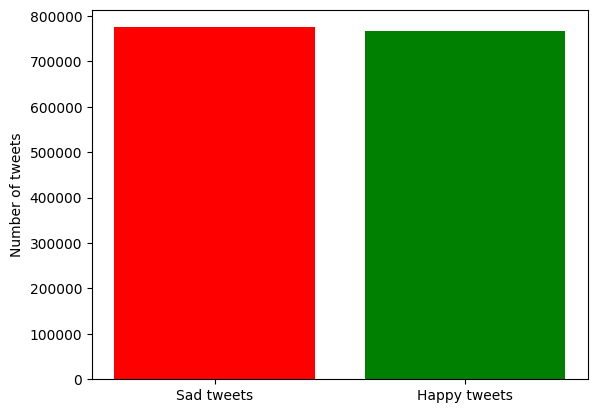

In [27]:
(figure_, axes_) = plt.subplots()

y = [sad_tweets_count, happy_tweets_count]
axes_.set_ylabel("Number of tweets")

x = ["Sad tweets", "Happy tweets"]

axes_.bar(x, y, color = ["red", "green"])
plt.show()

### Balancing dataframes

In [28]:
sad_tweets = sad_tweets.select("*").orderBy(rand())
sad_tweets = sad_tweets.limit(happy_tweets_count)

tweets_df = sad_tweets.union(happy_tweets)

---
## **Word Vector representation**

### Load **GloVe** embeddings

In [29]:
import gensim.downloader as api

embeddings = 100
word2vector = None

if word2vector == None:
  word2vector = api.load("glove-twitter-" + str(embeddings))

### Mapping tokens - embeddings

In [30]:
extractor_udf = udf(lambda tokens: [[float(x) for x in word2vector[token]] if token in word2vector else [float(0.0)]*word2vector["tweet"].shape[0] for token in tokens], ArrayType((ArrayType(FloatType()))))

avg_embedding_udf = udf(lambda x :[float(y) for y in np.mean(x, axis = 0)])

tweets_embedded = tweets_df.withColumn("tweet_embeddings", extractor_udf("terms_stemmed"))
tweets_embedded = tweets_embedded.withColumn("tweet_embeddings", avg_embedding_udf("tweet_embeddings"))

#tweets_embedded.printSchema()
#tweets_embedded.show(7, truncate = False)


### Conversion from `ArrayType( ArrayType( Float() ) )` to `VectorUDT()`

In [31]:
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector_udf = udf(lambda embedded: Vectors.dense(embedded), VectorUDT())

tweets_embedded = tweets_embedded.withColumn("tweet_embeddings", to_vector_udf(tweets_embedded.tweet_embeddings))


---
## **Train and Test setup**

In [32]:
#tweets_embedded.cache()

(train_df, test_df) = tweets_embedded.randomSplit([0.8, 0.2], seed=1234)

train_df_count = train_df.count()

### **Assign weights** to unbalanced columns

In [33]:
# calculate the weights for the train set
class_weights_train = train_df.groupBy('target').count().withColumn('class_weight_train', 1 / col('count'))
hour_weights_train = train_df.groupBy('hour').count().withColumn('hour_weight_train', col('count') / train_df_count)
day_weights_train = train_df.groupBy('day_name').count().withColumn('day_weight_train', col('count') / train_df_count)

# join the weights
train_df_weighted = train_df.join(class_weights_train, 'target', 'left').join(hour_weights_train, 'hour', 'left').join(day_weights_train, 'day_name', 'left')

# fill null values in case of missing values
train_df_weighted = train_df_weighted.fillna(0.0, subset=['class_weight_train', 'hour_weight_train', 'day_weight_train'])

train_df_weighted = train_df_weighted.withColumn('terms_stemmed', col('terms_stemmed'))
train_df_weighted = train_df_weighted.withColumn('tweet_embeddings', col('tweet_embeddings'))

# delete "count" columns
#  cannot delete columns with the same name, so I rename them
df_cols = train_df_weighted.columns

duplicate_col_index = [idx for idx, val in enumerate(df_cols) if val in df_cols[:idx]]

cols_to_remove = list()

for i in duplicate_col_index:
    df_cols[i] = 'count_'+ str(i)
    cols_to_remove.append(col(df_cols[i]))

train_df_weighted = train_df_weighted.toDF(*df_cols)

cols_to_remove.append(col("count"))
train_df_weighted = train_df_weighted.drop(*cols_to_remove)

#train_df_weighted.show(5)


### Combine weighted columns

In [34]:
from pyspark.ml.feature import VectorAssembler, CountVectorizer

train_df_weighted = train_df_weighted.withColumn("combined_weight", train_df_weighted["class_weight_train"] * train_df_weighted["hour_weight_train"] * train_df_weighted["day_weight_train"])
test_df = test_df.withColumn("combined_weight", lit(1.0))

assembler = VectorAssembler(inputCols = ["hour", "day_name", "tweet_embeddings"], outputCol = "features")

# before the VectorAssembler I need to handle the string data "day_name"
days_map = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6, "Sun": 7}

convert_day_name_udf = udf(lambda day_name : days_map[day_name], IntegerType())

train_df_weighted = train_df_weighted.withColumn("day_name", convert_day_name_udf(train_df_weighted.day_name))
test_df = test_df.withColumn("day_name", convert_day_name_udf(test_df.day_name))

# apply the VectorAssembler
train_df_weighted = assembler.transform(train_df_weighted).select("features", "target", "combined_weight")
test_df = assembler.transform(test_df).select("features", "target", "combined_weight")

In [35]:
#train_df_weighted.show(2)

---
## **Load ready-to-use dataset**
Load train and test cleaned and preprocessed datasetes `.parquet`

In [ ]:
from google.colab import files

#train_dataset_parquet = files.upload()
#test_dataset_parquet = files.upload()

Saving part-00000-2ca64f1f-1881-4e69-9494-40e8764fe08e-c000.snappy.parquet to part-00000-2ca64f1f-1881-4e69-9494-40e8764fe08e-c000.snappy.parquet


In [ ]:
#test_df = spark.read.parquet("/content/part-00000-2ca64f1f-1881-4e69-9494-40e8764fe08e-c000.snappy.parquet")
#test_df.show(10)

+--------------------+------+---------------+
|            features|target|combined_weight|
+--------------------+------+---------------+
|[0.0,5.0,0.003392...|     0|            1.0|
|[0.0,5.0,0.110541...|     0|            1.0|
|[0.0,5.0,-0.02370...|     0|            1.0|
|[0.0,5.0,-0.00917...|     0|            1.0|
|[0.0,5.0,-0.08935...|     0|            1.0|
|[0.0,5.0,-0.12956...|     0|            1.0|
|[0.0,5.0,0.132862...|     0|            1.0|
|[0.0,5.0,-0.01341...|     0|            1.0|
|[0.0,5.0,-0.05852...|     0|            1.0|
|[0.0,5.0,0.081292...|     0|            1.0|
+--------------------+------+---------------+
only showing top 10 rows



---
## **Logistic Regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='target', weightCol='combined_weight')
lr_model = lr.fit(train_df_weighted)

predictions = lr_model.transform(test_df)

### Save model

In [ ]:
lr_model.save("LogisticRegressionModel")

---
## **Support Vector Classifier**

In [ ]:
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(featuresCol='features', labelCol='target')
svc_model = svc.fit(train_df_weighted)

predictions = svc_model.transform(test_df)

### Save model

In [ ]:
svc_model.save("SupportVectorModel")

---
## **Decision Tree Classifier**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt =  DecisionTreeClassifier(featuresCol='features', labelCol='target')
dt_model = dt.fit(train_df_weighted)

predictions = dt_model.transform(test_df)

### Save model

In [ ]:
dt_model.save("DecisionTreeModel")

---
## **Random Forest Classifier**


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='target')
rf_model = rf.fit(train_df_weighted)

predictions = rf_model.transform(test_df)

### Save model

In [ ]:
rf_model.save("RandomForestModel")

---
## **Load models**

In [34]:
! sudo apt install subversion

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2 subversion
0 upgraded, 6 newly installed, 0 to remove and 16 not upgraded.
Need to get 2,672 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libapr1 amd64 1.7.0-8ubuntu0.22.04.1 [108 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libaprutil1 amd64 1.6.1-5ubuntu4.22.04.1 [92.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libserf-1-1 amd64 1.3.9-10ubuntu2 [50.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libutf8proc2 amd64 2.7.0-3 [73.9 kB]
Get:5 http://archive.

In [35]:
! svn export https://github.com/RiccardoRobb/BigData_project/trunk/Models

A    Models
A    Models/DecisionTreeModel
A    Models/DecisionTreeModel/data
A    Models/DecisionTreeModel/data/_SUCCESS
A    Models/DecisionTreeModel/data/part-00000-df68955c-05bc-4d4c-bdca-8b7adbf12532-c000.snappy.parquet
A    Models/DecisionTreeModel/metadata
A    Models/DecisionTreeModel/metadata/_SUCCESS
A    Models/DecisionTreeModel/metadata/part-00000
A    Models/LogisticRegressionModel
A    Models/LogisticRegressionModel/data
A    Models/LogisticRegressionModel/data/_SUCCESS
A    Models/LogisticRegressionModel/data/part-00000-8441a849-9c40-48cc-8f51-2b2ee2917b24-c000.snappy.parquet
A    Models/LogisticRegressionModel/metadata
A    Models/LogisticRegressionModel/metadata/_SUCCESS
A    Models/LogisticRegressionModel/metadata/part-00000
A    Models/RandomForestModel
A    Models/RandomForestModel/data
A    Models/RandomForestModel/data/_SUCCESS
A    Models/RandomForestModel/data/part-00000-a0f46889-5887-44ac-b7bf-cc7e8c31779d-c000.snappy.parquet
A    Models/RandomForestModel/metada

# **Evaluate Models**

In [ ]:
def evaluate_manually(predictions):
  # True positive, True negative, False positive and False negative
  tp = predictions.filter((predictions.target > 0) & (predictions.prediction > 0)).count()
  tn = predictions.filter((predictions.target == 0) & (predictions.prediction == 0)).count()
  fp = predictions.filter((predictions.target == 0) & (predictions.prediction > 0)).count()
  fn = predictions.filter((predictions.target > 0) & (predictions.prediction == 0)).count()

  # Calculate evaluation metrics
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)

  # Print the evaluation metrics
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1_score)

## Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel

loaded_lr_model = LogisticRegressionModel.load("/content/Models/LogisticRegressionModel")

predictions = loaded_lr_model.transform(test_df)
predictions.printSchema()
test_df.printSchema()

evaluate_manually(predictions)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)

Accuracy: 0.7141949649474864
Precision: 0.69628380184236
Recall: 0.7621010206071638
F1-Score: 0.7277072386491663


## Support Vector Classifier

In [ ]:
from pyspark.ml.classification import LinearSVCModel

loaded_svc_model = LinearSVCModel.load("/content/Models/SupportVectorModel")

predictions = loaded_svc_model.transform(test_df)
predictions.printSchema()
test_df.printSchema()

evaluate_manually(predictions)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)

Accuracy: 0.7173027807458758
Precision: 0.7150269701692611
Recall: 0.7247090944549177
F1-Score: 0.7198354765079437


## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassificationModel

loaded_dt_model = DecisionTreeClassificationModel.load("/content/Models/DecisionTreeModel")

predictions = loaded_dt_model.transform(test_df)
predictions.printSchema()
test_df.printSchema()

evaluate_manually(predictions)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)

Accuracy: 0.6246318834536498
Precision: 0.6569064186772452
Recall: 0.5253201586166547
F1-Score: 0.5837902660685002


## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel

loaded_rf_model = RandomForestClassificationModel.load("/content/Models/RandomForestModel")

predictions = loaded_rf_model.transform(test_df)
predictions.printSchema()
test_df.printSchema()

evaluate_manually(predictions)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)
 |-- combined_weight: double (nullable = false)

Accuracy: 0.6580913971488885
Precision: 0.6675764079846944
Recall: 0.6328544497172203
F1-Score: 0.6497518846422099


---
## Verify data

In [ ]:
#tweets_embedded.printSchema()
#tweets_embedded.show(10)

#print("tot = ", tweets_embedded.count())

# TODO
* **Are useful tokens with len==1 ?**
* **chek udf validity for month/day mapping**
* **validation set?**
* **confusion matrix for svc**
* **confusion matrix for decisiontree**
* **evaluation one-for-all using *Pandas classification_report***
---
* **compare weighted and not weighted?**
* **compare 1dataset with 0dataset?**